# Лабораторная работа №0
## ИНСТРУМЕНТАЛЬНЫЕ СРЕДСТВА АНАЛИЗА И ПРОГНОЗИРОВАНИЯ ВРЕМЕННЫХ РЯДОВ
Комлева Юлия Владимировна

Вариант: 9

Группа: РИМ-281226
### Декомпозиция ВР вида 3 кратные сезонные компоненты + шум.

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
import random
import pandas as pd
import scipy
import math
from scipy.stats import f, norm
import scipy as sp
from scipy import signal


%matplotlib inline

### Кратные сезонные компоненты

In [2]:
random.seed(13)
np.random.seed(13)

t = np.linspace(0, 1, 1024)

#линейная частота сезона
f = 10 #P = 1/10

S1 = np.sin(2*np.pi*2*f*t)
S2 = np.sin(2*np.pi*4*f*t)
S3 = np.sin(2*np.pi*8*f*t)

noise = 0.2*rand.randn(len(t))

S = S1 + S2 + S3 + noise

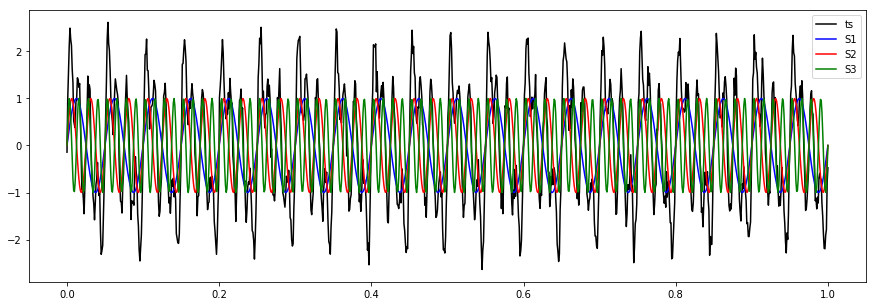

In [3]:
plt.figure(figsize = (15, 5))
plt.plot(t, S, 'k', label = 'ts')
plt.plot(t, S1, 'b', label = 'S1')
plt.plot(t, S2, 'r', label = 'S2')
plt.plot(t, S3, 'g', label = 'S3')
plt.legend()
plt.show()

### Функции для проверки случайности ряда остатков

In [4]:
def mean_res_test(noise):
    m = np.mean(noise)
    σ = np.sqrt(np.var(noise))
    statistic = m/σ * np.sqrt(1024)
    print("\n===mean-res-test===")
    
    alpha = 0.05
    df = N - 1
    rejection_reg = scipy.stats.t.ppf(1-alpha, df)
    #abs
    print("\tstatistic %.3f < critical value %.3f" % (statistic, rejection_reg))
    print("\tH0: M[e] = 0 CORRECT")

In [5]:
def turning_point(a, b, c):
    result = 0       # not a turning point
    if ((a < b) and (b > c)):
        result = 1    # turning max
    elif ((a > b) and (b < c)):
        result = -1   # turning min
    return result

def turning_point_test(noise):
    print("\n===turning-point-test===")
    cnt = 0  # счётчик поворотных точек
    for i in range(1, N-1):
        cnt += abs(turning_point(noise[i-1], noise[i], noise[i+1]))

    d = (16.0 * N - 29.0) / 90.0  # дисперсия 
    rejection_reg = 1.96 * math.sqrt(d)    # пороговое отклонение для вероятности 0.95

    statistic = cnt - 2/3*(N-2)
    print("\tstatistic %.3f < critical value %.3f" % (statistic, rejection_reg))
    print("\tH0: M[e] = 0 CORRECT")
    

In [6]:
def noise_test(noise):
    
    plt.figure(figsize = (15, 5))
    plt.title("noise")
    plt.plot(t, noise, label='noise')

    plt.legend()
    plt.show()
    
    mean_res_test(noise)
    turning_point_test(noise)

### Функции для построения спектрограмм и мгновенной частоты

In [7]:
def plot_spectrograms(s1, s2, s3, S, noise):
    fs = 1/(t[1] - t[0]) # fs = 1/dt = N/T
    f1, ts1, Sxx1 = signal.spectrogram(s1, fs) # возвращаем частоту от времени
    f2, ts2, Sxx2 = signal.spectrogram(s2, fs) # возвращаем частоту от времени
    f3, ts3, Sxx3 = signal.spectrogram(s3, fs) # возвращаем частоту от времени
    fS, tsS, SxxS = signal.spectrogram(S, fs) # возвращаем частоту от времени
    fnoise, tsnoise, Sxxnoise = signal.spectrogram(noise, fs) # возвращаем частоту от времени
    
    fig, ax = plt.subplots(5, 1, figsize=(16, 16), sharex=True)
    ax[0].pcolormesh(ts1, f1, Sxx1)
    ax[0].set_title("f1 = 20")
    
    ax[1].pcolormesh(ts2, f2, Sxx2)
    ax[1].set_title("f2 = 40")
    
    ax[2].pcolormesh(ts3, f3, Sxx3)
    ax[2].set_title("f3 = 80")
    
    ax[3].pcolormesh(tsS, fS, SxxS)
    ax[3].set_title("S = s1 + s2 + s3 + noise")
    
    ax[4].pcolormesh(tsnoise, fnoise, Sxxnoise)
    ax[4].set_title("noise")
    ax[4].set_xlabel("Time [sec]")
  
    for a in ax.flat:
        a.set(ylabel='Frequency [Hz]', ylim=(0,100))
    plt.show()

In [8]:
def hilbert_instantaneous_frequency(s):
    fs = 1/(t[1] - t[0])
    # аналитический сигнал
    analytic_signal = signal.hilbert(s)
    # мгновенная фаза в развернутом непрерывном виде
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # мгновенная частота как производная от фазы, приведенная в Гц
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
    return instantaneous_frequency

def plot_hilbert(s1, s2, s3, noise):
    instantaneous_frequency_s1 = hilbert_instantaneous_frequency(s1)
    instantaneous_frequency_s2 = hilbert_instantaneous_frequency(s2)
    instantaneous_frequency_s3 = hilbert_instantaneous_frequency(s3)
    instantaneous_frequency_noise = hilbert_instantaneous_frequency(noise)
    
    t_cut = t[1:]
    fig, ax = plt.subplots(5, 1, figsize=(16, 10))
    ax[0].plot(t_cut, instantaneous_frequency_s1, 'b', label="f1 = 10 * 2 = 20")
    ax[0].plot(t_cut, [20]*1023, 'g', label="base 20")
    ax[1].plot(t_cut, instantaneous_frequency_s2, 'r', label="f2 = 10 * 4 = 40")
    ax[1].plot(t_cut, [40]*1023, 'g', label="base 40")
    ax[2].plot(t_cut, instantaneous_frequency_s3, 'k', label="f3 = 10 * 8 = 80")
    ax[2].plot(t_cut, [80]*1023, 'g', label="base 80")
    
    ax[3].plot(t_cut, instantaneous_frequency_s1, 'b', label='f1')
    ax[3].plot(t_cut, [20]*1023, 'g', label='base f1')
    ax[3].plot(t_cut, instantaneous_frequency_s2, 'r', label='f2')
    ax[3].plot(t_cut, [40]*1023, 'g', label='base f2')
    ax[3].plot(t_cut, instantaneous_frequency_s3, 'k', label='f3')
    ax[3].plot(t_cut, [80]*1023, 'g', label='base f3')
    
    ax[4].plot(t_cut, instantaneous_frequency_noise, 'k', label="noise")

    for a in ax.flat:
        a.grid()
        a.legend()
    
    plt.show()

# Декомпозиция ВР
## 1. SSA
Метод Сингулярного Спектрального Анализа SSA  (lab 5)

In [9]:
def SSA_modes(F, L):
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K))
    #шаг вложения
    for i in range(0, L): #rows
        for j in range(0, K):
            X[i,j] = F[i+j]
    #X = np.column_stack([F[i:i+L] for i in range(0,K)])
    #шаг сингулярного разложени]
    S = np.dot(X, X.T)
    U, A, _ = np.linalg.svd(S)
    # U - матрица собственных векторов
    # A - массив собственных чисел (в неубывающем порядке)
    V = np.dot(X.T, U) #матрица траекторных векторов
    return A, U, V

In [10]:
def SSA_group(A, U, V, N, I):
    
    L = len(A)
    K = N - L + 1

    #шаг группировки
    V = V.transpose()
    Z = np.dot(U[:, I], V[I, :])

    #этап диагонального усреднения
    G = np.zeros(N)
    L_ = min(L, K)
    K_ = max(L, K)    
    
    for k in range(0, L_):
        for m in range(0, k + 1):
            G[k] += Z[m][k-m]
        G[k] *= 1/(k+1)
    for k in range(L_, K_):
        for m in range(0, L_):    
            G[k] += Z[m][k-m]   
        G[k] *= 1/L_
    for k in range(K_, N):
        for m in range(k-K_+1, N-K_+1):
            G[k] += Z[m][k-m]
        G[k] *= 1/(N-k)
    return G

In [11]:
N = 1024
L = 39
K = N-L+1
w_min_diff = 1/min(L,K)
print(w_min_diff)

0.02564102564102564


#### Выбор ширины окна

In [12]:
arr1 = []
arr2 = []
arr3 = []
s1 = S1 #S2 S3
s2 = S2
s3 = S3
for i in range(2, 100):
    A, U, V = SSA_modes(S, i)
    ssaF = SSA_group(A, U, V, len(S), [0])
    arr1.append(sum(abs(s1 - ssaF)))
    arr2.append(sum(abs(s2 - ssaF)))
    arr3.append(sum(abs(s3 - ssaF)))
    #print(i, sum(abs(trend - ssaF)))

In [13]:
L1 = np.argmin(arr1)+2
L2 = np.argmin(arr2)+2
L3 = np.argmin(arr3)+2
L1, L2, L3

(39, 18, 52)

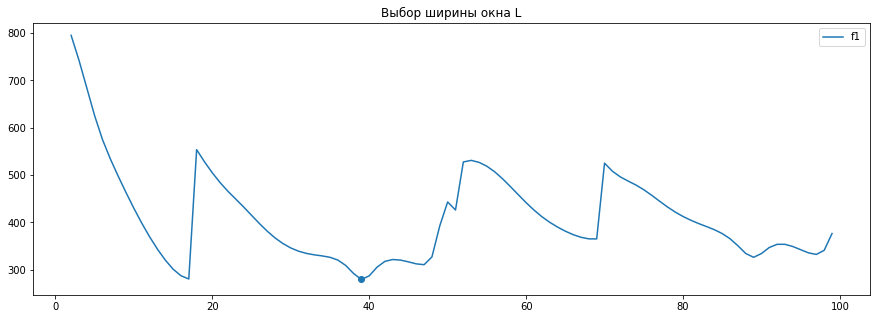

In [14]:
plt.figure(figsize = (15, 5))
plt.title("Выбор ширины окна L")
plt.plot(range(2, 100), arr1, label='f1')
#plt.plot(range(2, 100), arr2, label='f2')
#plt.plot(range(2, 100), arr3, label='f3')
plt.scatter(L1, arr1[L1-2]) # np.argmin(arr) + 2
#plt.scatter(L2, arr2[L2-2]) # np.argmin(arr) + 2
#plt.scatter(L3, arr3[L3-2]) # np.argmin(arr) + 2

plt.legend()
plt.show()

In [15]:
L = L1 #39

In [16]:
A, U, V = SSA_modes(S, L)

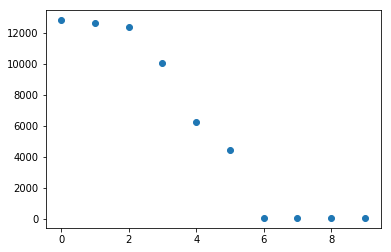

In [17]:
plt.scatter(range(10),A[:10])
plt.show()

In [18]:
A, U, V = SSA_modes(S, L)
ssaF0 = SSA_group(A, U, V, len(S), [0])
ssaF1 = SSA_group(A, U, V, len(S), [1])
ssaF2 = SSA_group(A, U, V, len(S), [2])
ssaF3 = SSA_group(A, U, V, len(S), [3])
ssaF4 = SSA_group(A, U, V, len(S), [4])
ssaF5 = SSA_group(A, U, V, len(S), [5])

ssaF01 = SSA_group(A, U, V, len(S), [0, 1])
ssaF02 = SSA_group(A, U, V, len(S), [0, 2])
ssaF03 = SSA_group(A, U, V, len(S), [0, 3])
ssaF04 = SSA_group(A, U, V, len(S), [0, 4])
ssaF05 = SSA_group(A, U, V, len(S), [0, 5])

ssaF12 = SSA_group(A, U, V, len(S), [1, 2])
ssaF13 = SSA_group(A, U, V, len(S), [1, 3])
ssaF14 = SSA_group(A, U, V, len(S), [1, 4])
ssaF15 = SSA_group(A, U, V, len(S), [1, 5])

ssaF23 = SSA_group(A, U, V, len(S), [2, 3])
ssaF24 = SSA_group(A, U, V, len(S), [2, 4])
ssaF25 = SSA_group(A, U, V, len(S), [2, 5])

ssaF34 = SSA_group(A, U, V, len(S), [3, 4])
ssaF35 = SSA_group(A, U, V, len(S), [3, 5])

ssaF45 = SSA_group(A, U, V, len(S), [4, 5])

ssaF234 = SSA_group(A, U, V, len(S), [2, 3, 4])

ssaF6 = SSA_group(A, U, V, len(S), [6]) # уже лишнее

### Без группировки компонент

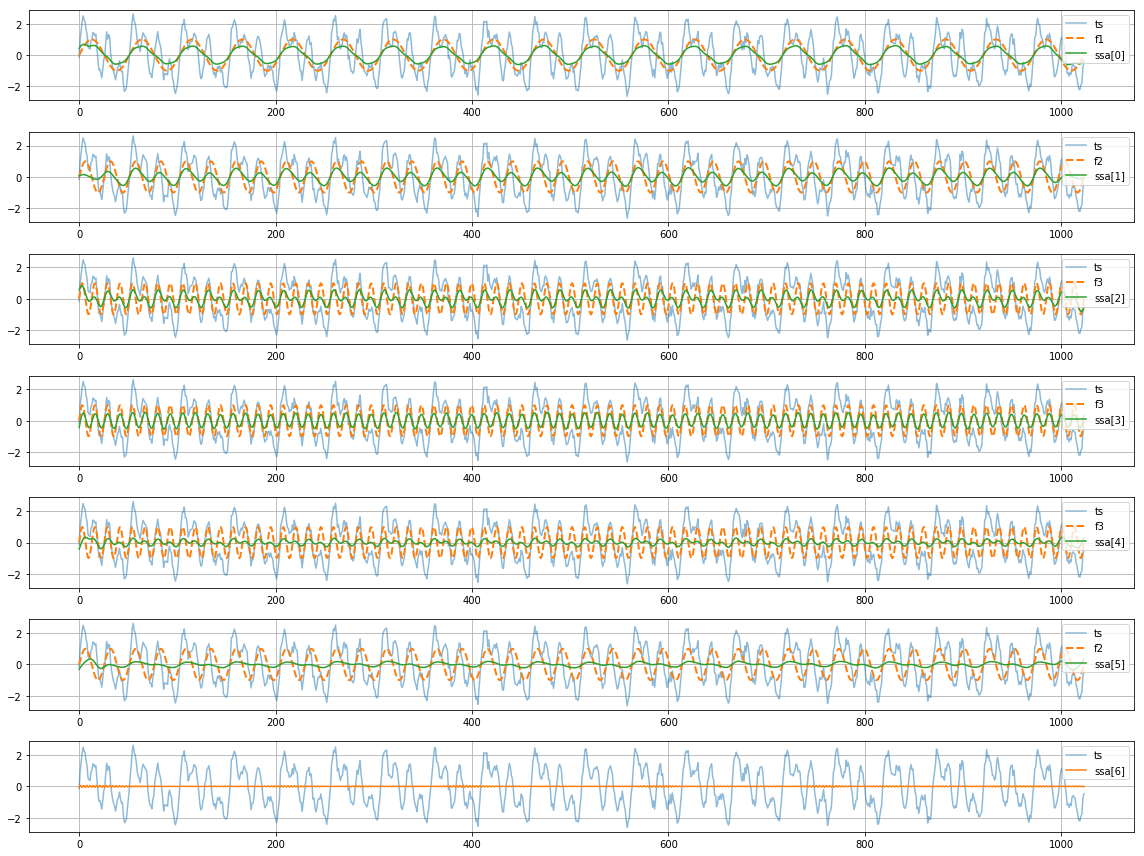

In [19]:
fig, ax = plt.subplots(7, 1, figsize=(16, 12), sharey = True)

ax[0].plot(S, label = 'ts', alpha=0.5)
ax[0].plot(range(1024), S1, ls = '--', lw = 2, label = 'f1')
ax[0].plot(ssaF0, label = 'ssa[0]')

ax[1].plot(S, label = 'ts', alpha=0.5)
ax[1].plot(range(1024), S2, ls = '--', lw = 2, label = 'f2')
ax[1].plot(ssaF1, label = 'ssa[1]')

ax[2].plot(S, label = 'ts', alpha=0.5)
ax[2].plot(range(1024), S3, ls = '--', lw = 2, label = 'f3')
ax[2].plot(ssaF2, label = 'ssa[2]')

ax[3].plot(S, label = 'ts', alpha=0.5)
ax[3].plot(range(1024), S3, ls = '--', lw = 2, label = 'f3')
ax[3].plot(ssaF3, label = 'ssa[3]')

ax[4].plot(S, label = 'ts', alpha=0.5)
ax[4].plot(range(1024), S3, ls = '--', lw = 2, label = 'f3')
ax[4].plot(ssaF4, label = 'ssa[4]')

ax[5].plot(S, label = 'ts', alpha=0.5)
ax[5].plot(range(1024), S2, ls = '--', lw = 2, label = 'f2')
ax[5].plot(ssaF5, label = 'ssa[5]')

ax[6].plot(S, label = 'ts', alpha=0.5)
ax[6].plot(ssaF6, label = 'ssa[6]')



for a in ax.flat:
    a.grid()
    a.legend()



plt.tight_layout()
plt.show()

### С группировкой компонент

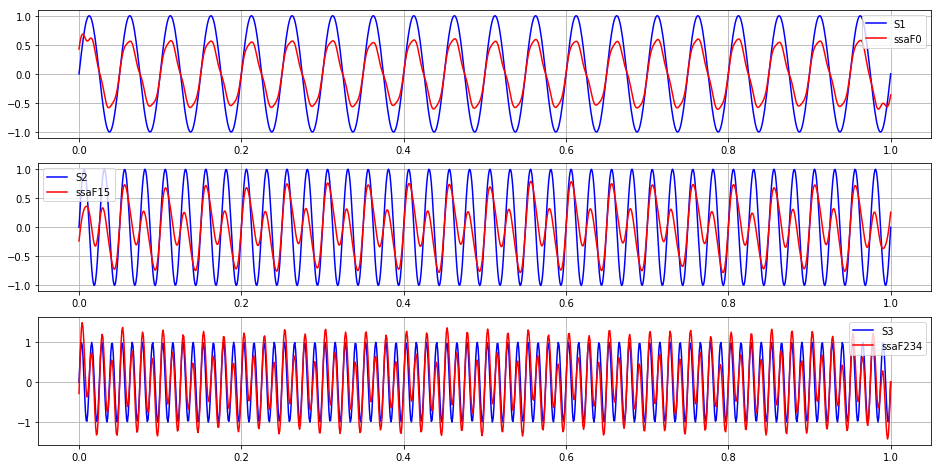

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(16, 8))
ax[0].plot(t, S1, 'b', label='S1')
ax[0].plot(t, ssaF0, 'r', label='ssaF0')

ax[1].plot(t, S2, 'b', label='S2')
ax[1].plot(t, ssaF15, 'r', label='ssaF15')

ax[2].plot(t, S3, 'b', label='S3')
ax[2].plot(t, ssaF234, 'r', label='ssaF234') 

for a in ax.flat:
    a.grid()
    a.legend()
plt.show()

### SSA: Проверка случайности ряда остатков

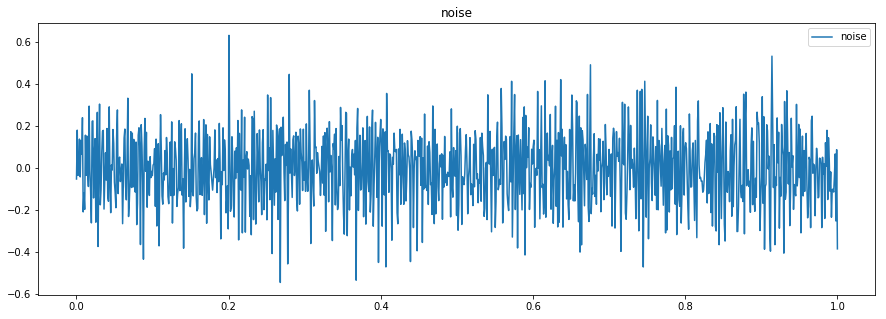


===mean-res-test===
	statistic -0.605 < critical value 1.646
	H0: M[e] = 0 CORRECT

===turning-point-test===
	statistic 21.667 < critical value 26.422
	H0: M[e] = 0 CORRECT


In [21]:
noiseSSA = S - ssaF0  - ssaF234 - ssaF15
noise_test(noiseSSA)

### SSA: Спектрограмма компонент, всего ряда и шума

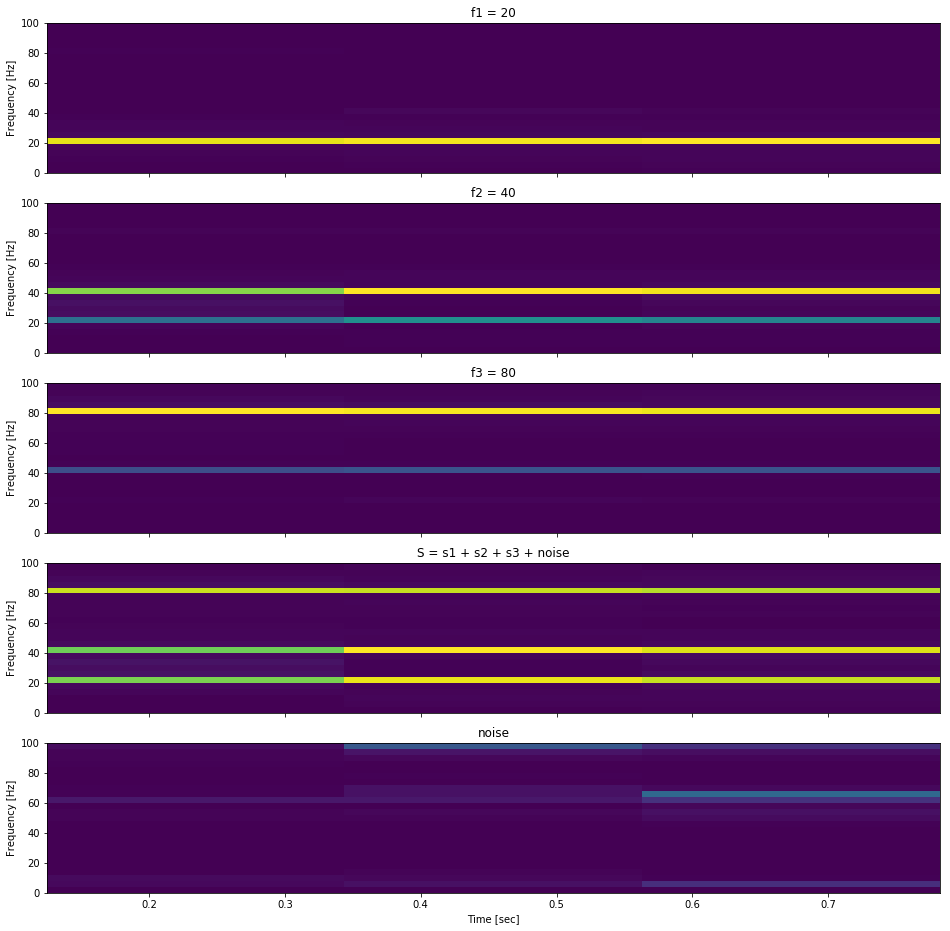

In [22]:
plot_spectrograms(ssaF0, ssaF15, ssaF234, S, noiseSSA)

### SSA: Функция мгновенной частоты от времени
Преобразование Гильберта

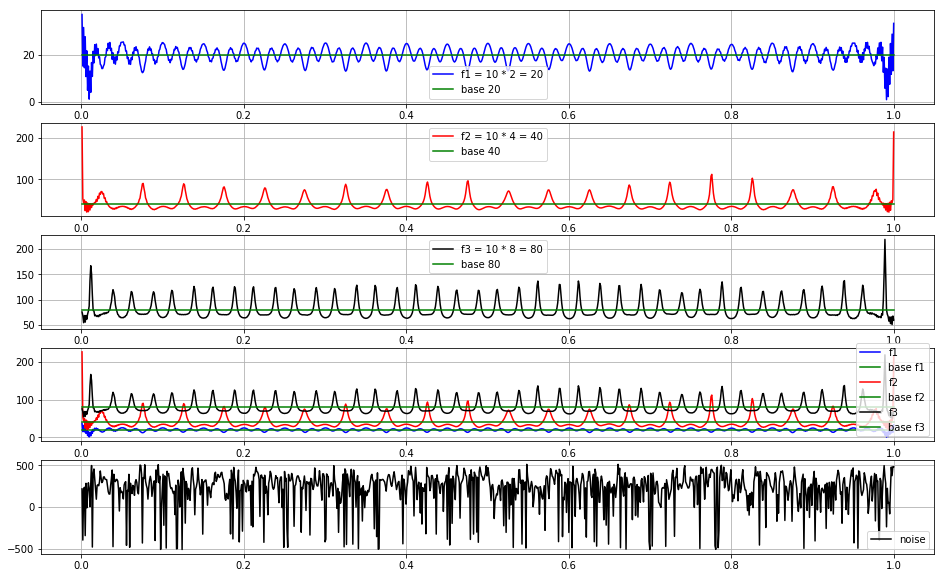

In [23]:
plot_hilbert(ssaF0, ssaF15, ssaF234, noiseSSA)

## 2. WPD
Wavelet Packet Decomposition
Метод Вейвлетной Декомпозиции (6)

In [24]:
import pywt

In [25]:
wp = pywt.WaveletPacket(data=S, wavelet='dmey', mode='periodization')
print([node.path for node in wp.get_level(4, 'freq')]) 

['aaaa', 'aaad', 'aadd', 'aada', 'adda', 'addd', 'adad', 'adaa', 'ddaa', 'ddad', 'dddd', 'ddda', 'dada', 'dadd', 'daad', 'daaa']


In [26]:
wp = pywt.WaveletPacket(data=S, wavelet='dmey', mode='periodization')
new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')

new_wp['aaaa'] = wp['aaaa'].data # выбираем первую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF1 = new_wp.data # восстанавливаем под нее ряд 1

new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aaad'] = wp['aaad'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF2 = new_wp.data # восстанавливаем под нее ряд 2

new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aadd'] = wp['aadd'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные
reF3 = new_wp.data # восстанавливаем под нее ряд 2

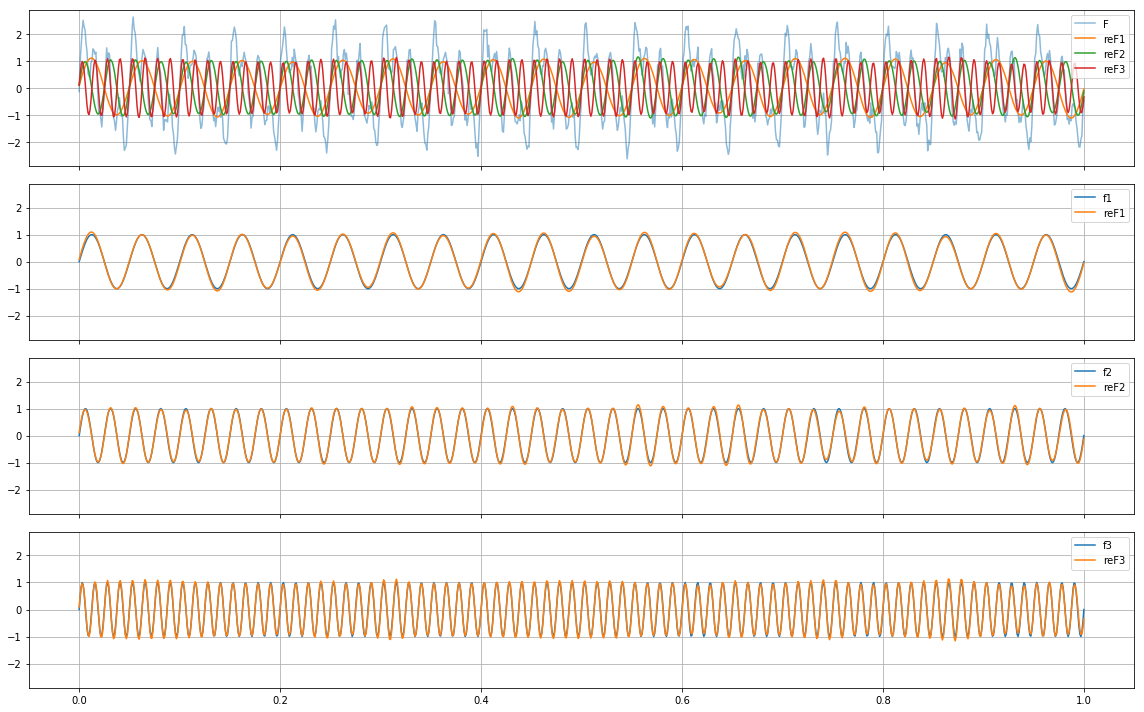

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(16, 10), sharex = True, sharey=True)
ax[0].plot(t, S, alpha = 0.5, label = 'F')
ax[0].plot(t, reF1, label = 'reF1') # нормируем на уровень 5
ax[0].plot(t, reF2, label = 'reF2') # нормируем на уровень 4
ax[0].plot(t, reF3, label = 'reF3') # нормируем на уровень 4

ax[1].plot(t, S1, label = 'f1')
ax[1].plot(t, reF1, label = 'reF1')

ax[2].plot(t, S2, label = 'f2')
ax[2].plot(t, reF2, label = 'reF2')

ax[3].plot(t, S3, label = 'f3')
ax[3].plot(t, reF3, label = 'reF3')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.tight_layout()
plt.show()

### WPD: Проверка случайности ряда остатков

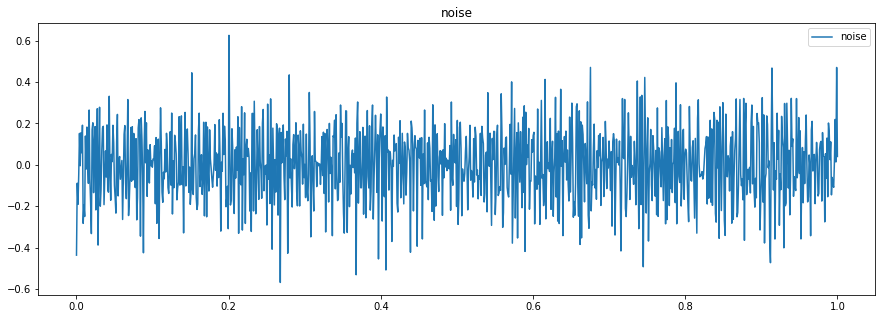


===mean-res-test===
	statistic -0.001 < critical value 1.646
	H0: M[e] = 0 CORRECT

===turning-point-test===
	statistic 19.667 < critical value 26.422
	H0: M[e] = 0 CORRECT


In [28]:
noiseWT = S - reF1 - reF2 - reF3
noise_test(noiseWT)

### WPD: Спектрограмма компонент, всего ряда и шума

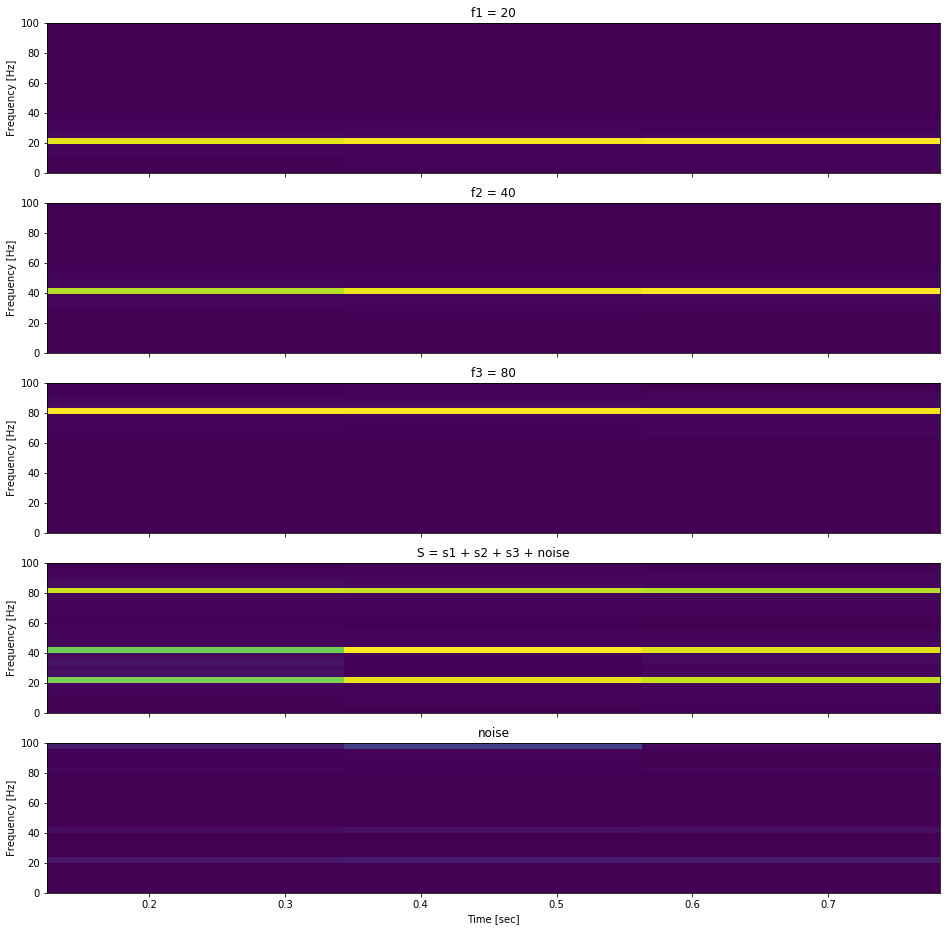

In [29]:
plot_spectrograms(reF1, reF2, reF3, S, noiseWT)

### WPD: Функция мгновенной частоты от времени
Преобразование Гильберта

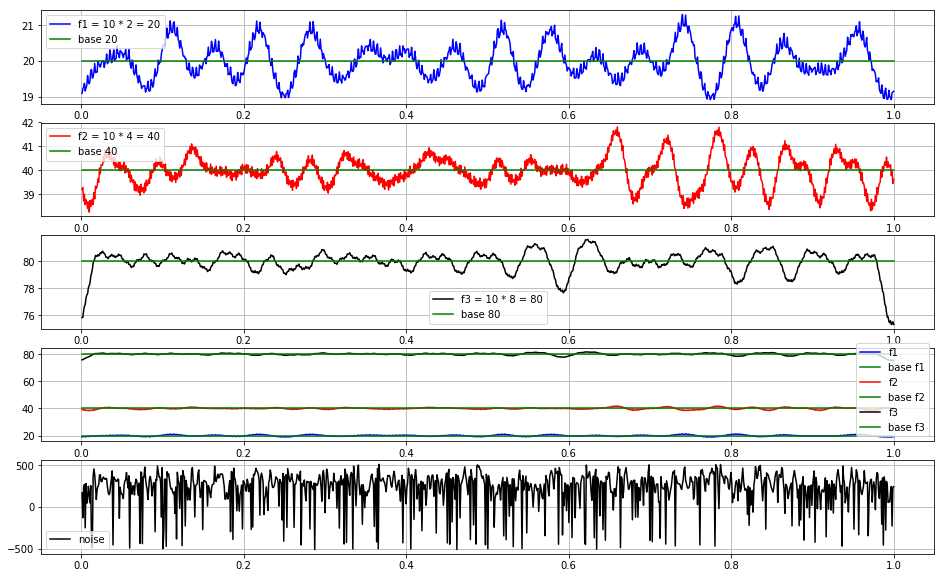

In [30]:
plot_hilbert(reF1, reF2, reF3, noiseWT)

## 3 EMD
Метод Эмпирической Модовой Декомпозиции (7)

In [31]:
def emd(x, n_components = 3):
    
    r = x
    rr = r
    t = np.arange(len(r))
    components = np.zeros(n_components + 1, dtype=object)
    for i in range(n_components):
        r_tmp = r
        for j in range(10):
            up_dots = sp.signal.argrelmax(r_tmp)[0]
            low_dots = sp.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = sp.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = sp.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            mean_t = _emd_complim(mean_t, up_dots, low_dots)
            
            #samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            #samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            #mean_t[:samp_start] = mean_t[samp_start]
            #mean_t[samp_end:] = mean_t[samp_end]
            


            r_tmp = r_tmp - mean_t
                
        
        components[i] = r_tmp
        r = r - components[i] 
    
    components[n_components] = r
    return components

def _emd_complim(mean_t, up_dots, low_dots):
    samp_start = np.max((np.min(up_dots),np.min(low_dots)))
    samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [32]:
def plot_emd(x, tx, tr, n_components, cut, window_len):
    components = emd(S, n_components)
    plt.figure(figsize=(16,8))
    for i in range(len(components)):
        
        plt.subplot(len(components),2,i*2+1)
        plt.plot(tx, x,color='0.6', label = 'F')
        plt.plot(tx, components[i],'k', label = 'component')
        plt.ylabel('component '+np.str(i+1))
        
    plt.tight_layout()
    plt.legend()
    return components

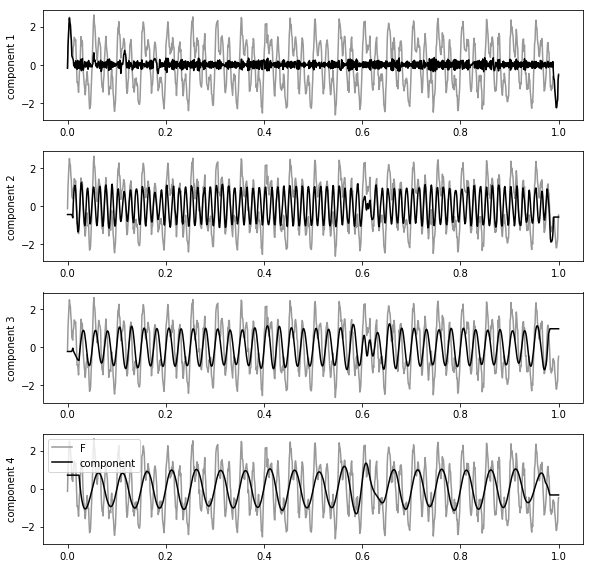

In [33]:
components = plot_emd(S, t, 'smooth', 3, 50, 51)

In [34]:
emd1, emd2, emd3 = components[3], components[2], components[1]

### EMD: Проверка случайности ряда остатков

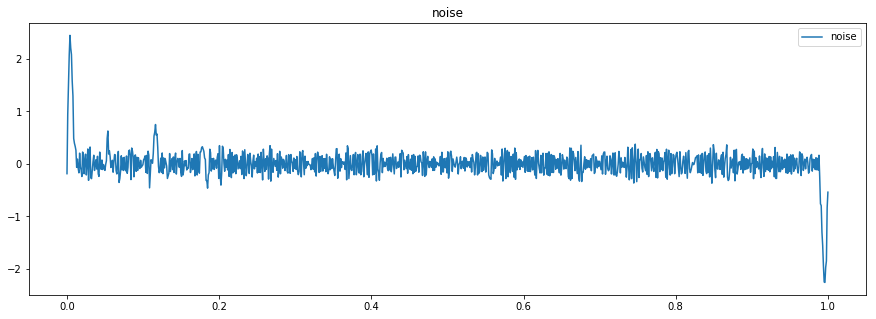


===mean-res-test===
	statistic 0.742 < critical value 1.646
	H0: M[e] = 0 CORRECT

===turning-point-test===
	statistic -7.333 < critical value 26.422
	H0: M[e] = 0 CORRECT


In [36]:
noiseEMD = S - emd1 - emd2 - emd3
noise_test(noiseEMD)

### EMD: Спектрограмма компонент, всего ряда и шума

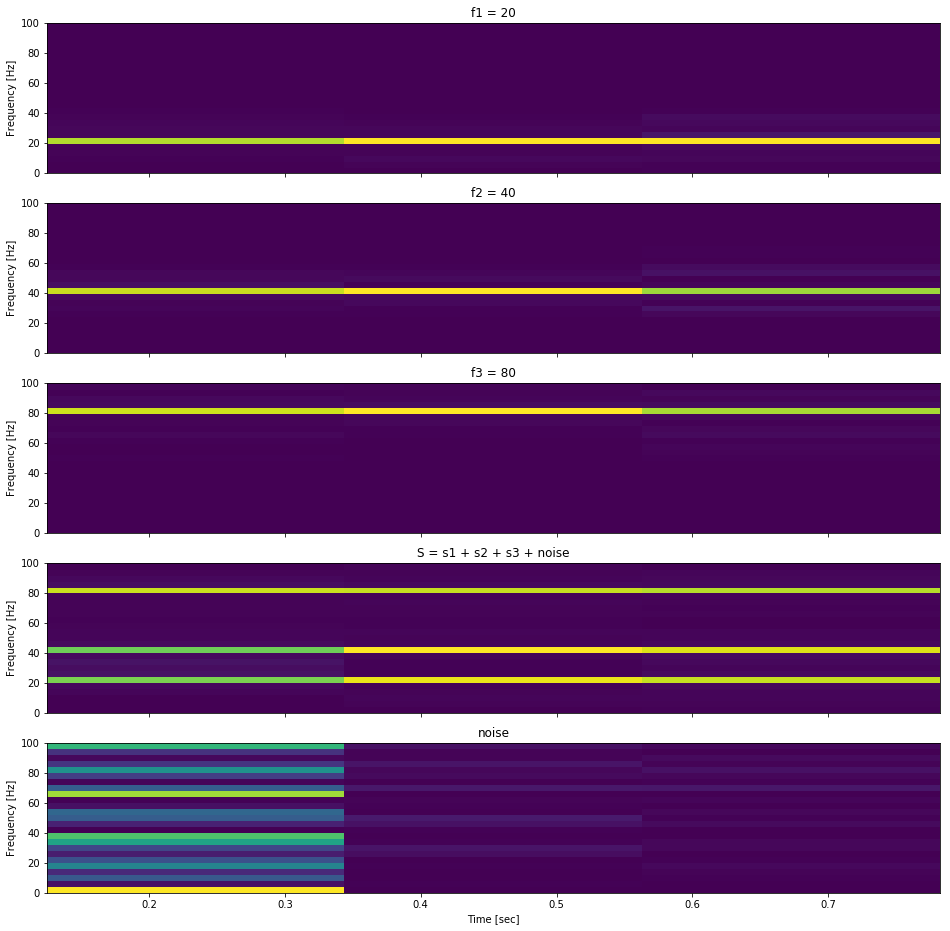

In [37]:
plot_spectrograms(emd1, emd2, emd3, S, noiseEMD)

### EMD: Функция мгновенной частоты от времени
Преобразование Гильберта

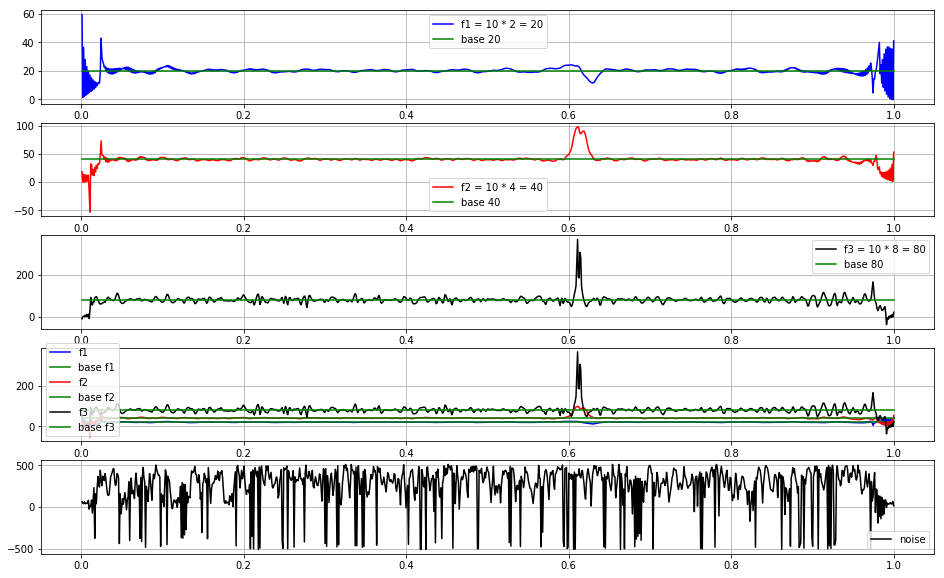

In [38]:
plot_hilbert(emd1, emd2, emd3, noiseEMD)